In [1]:
# Step 1: Install Required Libraries
!pip install -q yfinance plotly

In [2]:
# Step 2: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from datetime import datetime
import os

In [3]:
# Step 3: Load Dataset
df = pd.read_csv('/content/all_stocks_5yr.csv')
print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (619040, 7)


,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [4]:
# Step 4: Data Preprocessing
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['Name', 'date'])

In [5]:
# Let's choose one stock for prediction (e.g., Apple - 'AAPL')
apple_df = df[df['Name'] == 'AAPL'][['date', 'close']]
apple_df = apple_df.set_index('date')

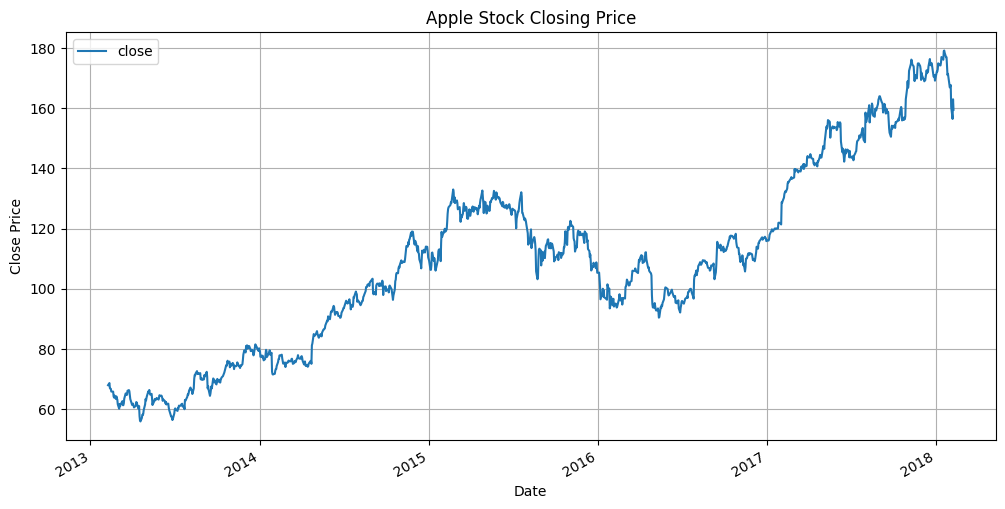

In [6]:
# Visualize the trend
apple_df.plot(figsize=(12, 6), title='Apple Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid()
plt.show()

In [7]:
# Step 5: Normalize the Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(apple_df)

In [8]:
# Step 6: Create Training and Testing Data
def create_dataset(dataset, time_step=60):
    X, Y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

training_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:training_size]
test_data = scaled_data[training_size - 60:]

X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)

In [9]:
# Reshape for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [10]:
# Step 7: Build LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Step 8: Train the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.0751 - val_loss: 0.0346
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0066 - val_loss: 0.0039
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0040 - val_loss: 0.0132
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0026 - val_loss: 0.0062
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0

In [13]:
# Step 9: Predict and Inverse Transform
predictions = model.predict(X_test)
predicted_price = scaler.inverse_transform(predictions)
real_price = scaler.inverse_transform(y_test.reshape(-1, 1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


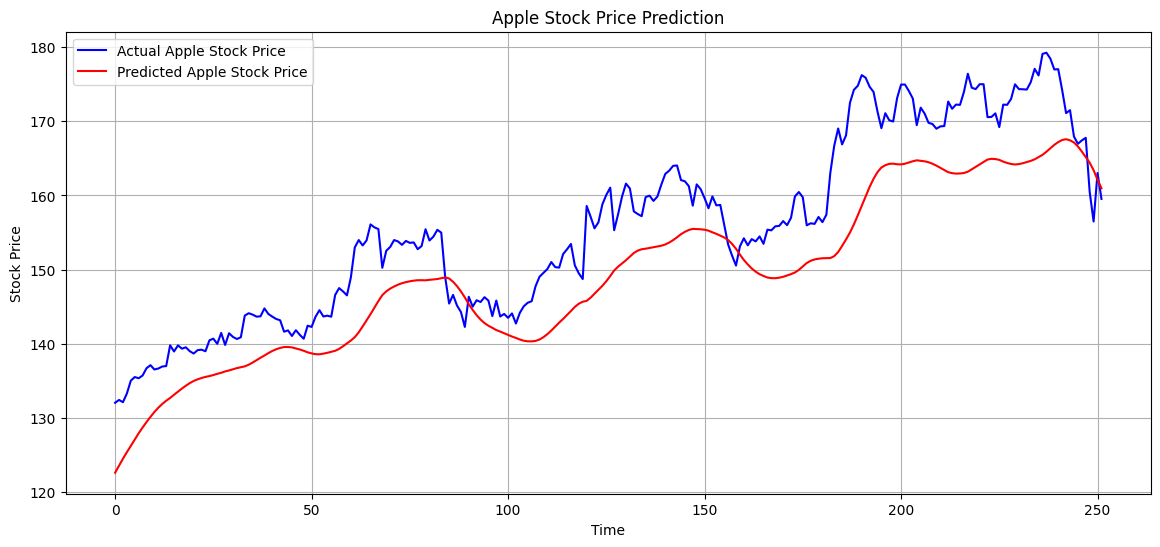

In [14]:
# Step 10: Plot Results
plt.figure(figsize=(14,6))
plt.plot(real_price, color='blue', label='Actual Apple Stock Price')
plt.plot(predicted_price, color='red', label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

In [15]:
# Evaluate Performance
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(real_price, predicted_price)
mae = mean_absolute_error(real_price, predicted_price)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 56.865191307458126
Mean Absolute Error: 6.676431239294627
